# CPSC 533R Visual AI - Assignment 1

In [29]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

In [92]:
# define a target device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)

cpu


In [71]:
# define a wrapper of a given dataset
class myMNIST_wrapper(torch.utils.data.Dataset):
  def __init__(self, *args, **kwargs):
    self.ds = torchvision.datasets.MNIST(*args, **kwargs)
    print('The dataset is initialized.')

  def __getitem__(self,index):
    img1, label1 = self.ds[index]
    index2 = torch.randint(0, len(self.ds), [1], dtype=torch.int).item()
    img2, label2 = self.ds[index2]
    # return dict(img, self.ds[index])
    if label1 == label2:
      matching_class_label = torch.ones(1, dtype=torch.bool)
    else:
      matching_class_label = torch.zeros(1, dtype=torch.bool)
    return {'img1':img1, 'img2':img2, 'matching_pair':matching_class_label}

  def __len__(self):
    return len(self.ds)

  # # Task IV: return two images and a binary variable
  # def pairs(self, index1, index2):
  #   img1, label1 = self.ds[index1]
  #   img2, label2 = self.ds[index2]
  #   if label1 == label2:
  #     matching_class_label = 1
  #   else:
  #     matching_class_label = 0
  #   return {'img1':img1, 'img2':img2, 'matching_pair':matching_class_label}

In [72]:
# Use standard FashionMNIST dataset
def gray_to_color(x):
    return x.repeat(3, 1, 1)

#train_set = torchvision.datasets.FashionMNIST(
train_set = myMNIST_wrapper(
    root = './DatasetFashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)

loader = torch.utils.data.DataLoader(train_set, batch_size = 8, num_workers=0)

The dataset is initialized.


The two images are: tensor([False])
The shape of the first image is:  torch.Size([3, 28, 28])
The shape of the second image is:  torch.Size([3, 28, 28])


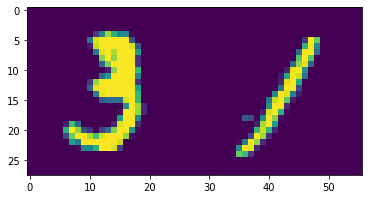

In [79]:
import matplotlib.pyplot as plt

idx  = 10
sample  = train_set[idx]
# for i,v in enumerate(sample):
#   if isinstance(v,torch.Tensor):
#     print(i,v.shape)
#   else:
#     print(i,v)

print("The two images are:", sample['matching_pair'])
print("The shape of the first image is: ", sample['img1'].shape)
print("The shape of the second image is: ", sample['img2'].shape)
plt.imshow(torch.cat([sample['img1'][0],
          sample['img2'][0]],dim=1).numpy().squeeze())

In [83]:
# define a model from scratch:
class myNN(nn.Module):
  def __init__(self, in_features=28*28, latent_dim= 128, out_dim=2, activation_layer=nn.ReLU()):
    # define a simple structure
    super().__init__()
    
    self.in_features = in_features
    self.out_dim = out_dim
    self.latent_dim = latent_dim
    self.activation_layer = activation_layer

    self.fc = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=self.latent_dim*4),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim*4, out_features=self.latent_dim*2),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim*2, out_features=self.latent_dim),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim, out_features=self.out_dim),
        )
  def forward(self, batch):
    # print(batch.shape)
    x = batch.flatten(start_dim=1,end_dim=-1)
    # print(x.shape)
    x = self.fc(x)
    # print(x.shape)

    return x

# define a wrapper for myNN which takes a dict batch
class myNN_dict(myNN):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # add a layer to the top
    fc_layers = list(self.fc)
    fc_layers.insert(1,nn.Dropout(p=0.5))
    self.fc = nn.Sequential(*fc_layers)
  
  # Task II: select input from a dictionary
  def forward(self, input_dict):
    y1 = super().forward(input_dict['img1'][0])
    y2 = super().forward(input_dict['img2'][0])
    d1 = y1.unsqueeze(1)
    d2 = y2.unsqueeze(0)
    dist_mat = ((d1-d2)**2).sum(-1)
    dist_mat = torch.abs((d1-d2).sum(-1))
    m = nn.Softmax(dim=1)
    prob_out = m(dist_mat)
    return {'prob':prob_out}

In [97]:
# get a batch
iterator = iter(train_loader)
batch = next(iterator)

print(batch)
print(batch['img1'])

{'img1': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],

KeyError: ignored

In [ ]:
sample = batch[1]
plt.imshow(torch.cat([sample[0],
          sample[1]],dim=2).cpu().numpy().squeeze())

In [ ]:
model_2 = myNN_dict(activation_layer=nn.Tanh()).to(device)
print(model_2)
# model_2.eval()
model_2.train()
result =model_2(batch)
print(result)

In [84]:
network = myNN_dict()

In [85]:
losses = []
iterator = iter(loader)
optimizer = optim.SGD(network.parameters(), lr=0.001)
for i in range(200): #range(len(loader)):
    batch = next(iterator)
    # Task III: modify the loss function
    preds = network(batch)
    loss = nn.functional.cross_entropy(preds, batch['matching_pair'])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i%10==0:
        print(i,losses[-1])

AttributeError: ignored

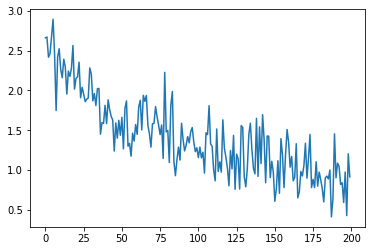

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)